In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [18]:
rnd = np.random.RandomState(42) #设置随机数种子
X = rnd.uniform(-3, 3, size=100) #random.uniform，从输入的任意两个整数中取出size个随机数

In [19]:
#生成y的思路：先使用NumPy中的函数生成一个sin函数图像，然后再人为添加噪音
y = np.sin(X) + rnd.normal(size=len(X)) / 3 #random.normal，生成size个服从正态分布的随机数

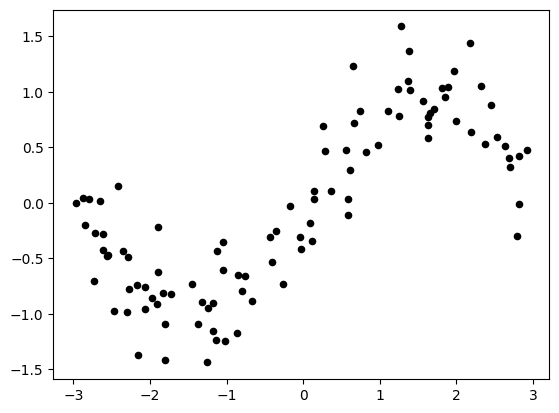

In [20]:
#使用散点图观察建立的数据集是什么样子
plt.scatter(X, y,marker='o',c='k',s=20)
plt.show()

In [21]:
#为后续建模做准备：sklearn只接受二维以上数组作为特征矩阵的输入
X.shape

(100,)

In [22]:
X = X.reshape(-1, 1)

In [23]:
X.shape

(100, 1)

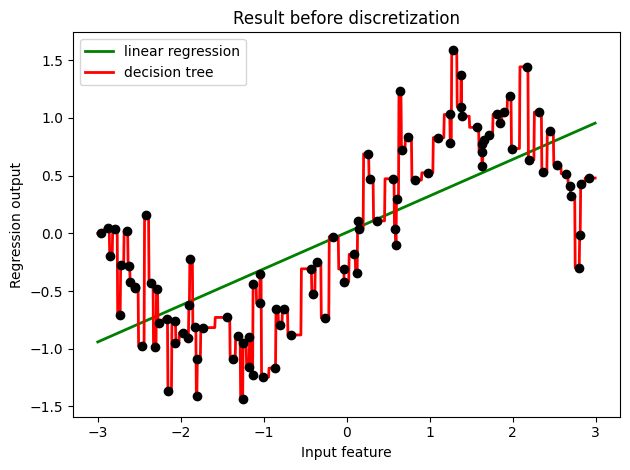

In [24]:
#使用原始数据进行建模
LinearR = LinearRegression().fit(X, y)
TreeR = DecisionTreeRegressor(random_state=0).fit(X, y)

#放置画布
fig, ax1 = plt.subplots(1)

#创建测试数据：一系列分布在横坐标上的点
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

#将测试数据带入predict接口，获得模型的拟合效果并进行绘制
ax1.plot(line, LinearR.predict(line), linewidth=2, color='green',
         label="linear regression")
ax1.plot(line, TreeR.predict(line), linewidth=2, color='red',
         label="decision tree")

#将原数据上的拟合绘制在图像上
ax1.plot(X[:, 0], y, 'o', c='k')

#其他图形选项
ax1.legend(loc="best")
ax1.set_ylabel("Regression output")
ax1.set_xlabel("Input feature")
ax1.set_title("Result before discretization")

plt.tight_layout()
plt.show()

In [25]:
from sklearn.preprocessing import KBinsDiscretizer

In [26]:
#将数据分箱
enc = KBinsDiscretizer(n_bins=10 #分几类？
                       ,encode="onehot") #ordinal

In [27]:
X_binned = enc.fit_transform(X)
#encode模式"onehot"：使用做哑变量方式做离散化
#之后返回一个稀疏矩阵(m,n_bins)，每一列是一个分好的类别
#对每一个样本而言，它包含的分类（箱子）中它表示为1，其余分类中它表示为0

In [28]:
X.shape

(100, 1)

In [29]:
X_binned

<100x10 sparse matrix of type '<class 'numpy.float64'>'
	with 100 stored elements in Compressed Sparse Row format>

In [30]:
#使用pandas打开稀疏矩阵
import pandas as pd
pd.DataFrame(X_binned.toarray()).head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
#我们将使用分箱后的数据来训练模型，在sklearn中，测试集和训练集的结构必须保持一致，否则报错
LinearR_ = LinearRegression().fit(X_binned, y)

In [32]:
LinearR_.predict(line) #line作为测试集
line.shape #测试

ValueError: X has 1 features, but LinearRegression is expecting 10 features as input.

In [34]:
X_binned.shape #训练

(100, 10)

In [35]:
#因此我们需要创建分箱后的测试集：按照已经建好的分箱模型将line分箱
line_binned = enc.transform(line)

In [36]:
line_binned.shape #分箱后的数据是无法进行绘图的

(1000, 10)

In [37]:
line_binned

<1000x10 sparse matrix of type '<class 'numpy.float64'>'
	with 1000 stored elements in Compressed Sparse Row format>

In [38]:
LinearR_.predict(line_binned).shape

(1000,)

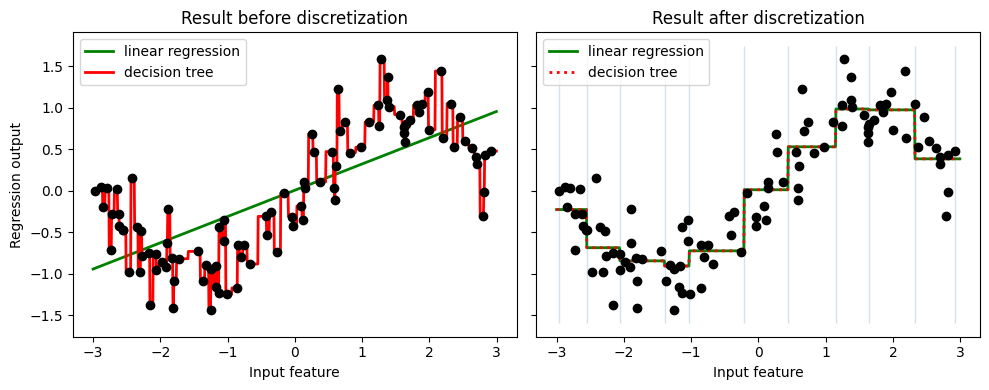

In [39]:
#准备数据
enc = KBinsDiscretizer(n_bins=10,encode="onehot")
X_binned = enc.fit_transform(X)
line_binned = enc.transform(line)
#将两张图像绘制在一起，布置画布
fig, (ax1, ax2) = plt.subplots(ncols=2
                               , sharey=True #让两张图共享y轴上的刻度
                               , figsize=(10, 4))
#在图1中布置在原始数据上建模的结果
ax1.plot(line, LinearR.predict(line), linewidth=2, color='green',
         label="linear regression")
ax1.plot(line, TreeR.predict(line), linewidth=2, color='red',
         label="decision tree")
ax1.plot(X[:, 0], y, 'o', c='k')
ax1.legend(loc="best")
ax1.set_ylabel("Regression output")
ax1.set_xlabel("Input feature")
ax1.set_title("Result before discretization")
#使用分箱数据进行建模
LinearR_ = LinearRegression().fit(X_binned, y)
TreeR_ = DecisionTreeRegressor(random_state=0).fit(X_binned, y)
#进行预测，在图2中布置在分箱数据上进行预测的结果
ax2.plot(line #横坐标
         , LinearR_.predict(line_binned) #分箱后的特征矩阵的结果
         , linewidth=2
         , color='green'
         , linestyle='-'
         , label='linear regression')
ax2.plot(line, TreeR_.predict(line_binned), linewidth=2, color='red',
         linestyle=':', label='decision tree')
#绘制和箱宽一致的竖线
ax2.vlines(enc.bin_edges_[0] #x轴
           , *plt.gca().get_ylim() #y轴的上限和下限
           , linewidth=1, alpha=.2)
#将原始数据分布放置在图像上
ax2.plot(X[:, 0], y, 'o', c='k')
#其他绘图设定
ax2.legend(loc="best")
ax2.set_xlabel("Input feature")
ax2.set_title("Result after discretization")
plt.tight_layout()
plt.show()

0.9566086751329097


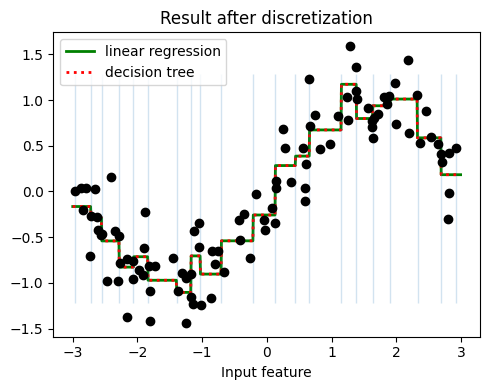

In [43]:
enc = KBinsDiscretizer(n_bins=20,encode="onehot")
X_binned = enc.fit_transform(X)
line_binned = enc.transform(line)

fig, ax2 = plt.subplots(1,figsize=(5,4))
LinearR_ = LinearRegression().fit(X_binned, y)
print(LinearR_.score(line_binned,np.sin(line)))
TreeR_ = DecisionTreeRegressor(random_state=0).fit(X_binned, y)
ax2.plot(line #横坐标
         , LinearR_.predict(line_binned) #分箱后的特征矩阵的结果
         , linewidth=2
         , color='green'
         , linestyle='-'
         , label='linear regression')
ax2.plot(line, TreeR_.predict(line_binned), linewidth=2, color='red',
         linestyle=':', label='decision tree')
ax2.vlines(enc.bin_edges_[0], *plt.gca().get_ylim(), linewidth=1, alpha=.2)
ax2.plot(X[:, 0], y, 'o', c='k')
ax2.legend(loc="best")
ax2.set_xlabel("Input feature")
ax2.set_title("Result after discretization")
plt.tight_layout()
plt.show()

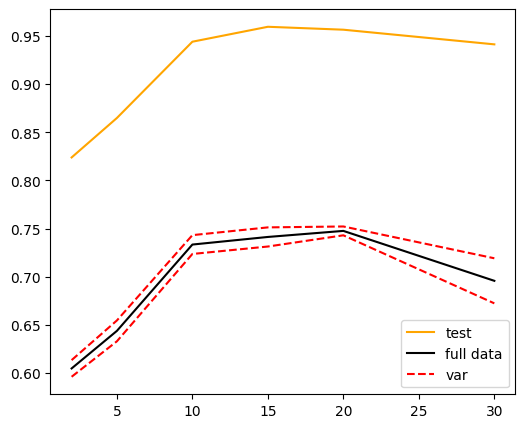

In [42]:
#怎样选取最优的箱子?
from sklearn.model_selection import cross_val_score as CVS
import numpy as np
pred,score,var = [], [], []
binsrange = [2,5,10,15,20,30]
for i in binsrange:
    #实例化分箱类
    enc = KBinsDiscretizer(n_bins=i,encode="onehot")
    #转换数据
    X_binned = enc.fit_transform(X)
    line_binned = enc.transform(line)
    #建立模型
    LinearR_ = LinearRegression()
    #全数据集上的交叉验证
    cvresult = CVS(LinearR_,X_binned,y,cv=5)
    score.append(cvresult.mean())
    var.append(cvresult.var())
    #测试数据集上的打分结果
    pred.append(LinearR_.fit(X_binned,y).score(line_binned,np.sin(line)))
#绘制图像
plt.figure(figsize=(6,5))
plt.plot(binsrange,pred,c="orange",label="test")
plt.plot(binsrange,score,c="k",label="full data")
plt.plot(binsrange,score+np.array(var)*0.5,c="red",linestyle="--",label = "var")
plt.plot(binsrange,score-np.array(var)*0.5,c="red",linestyle="--")
plt.legend()
plt.show()

In [44]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

In [45]:
#如果原始数据是一维的
X = np.arange(1,4).reshape(-1,1)

In [46]:
X

array([[1],
       [2],
       [3]])

In [47]:
#二次多项式，参数degree控制多项式的次方
poly = PolynomialFeatures(degree=2)

In [48]:
#接口transform直接调用
X_ = poly.fit_transform(X)
X_

array([[1., 1., 1.],
       [1., 2., 4.],
       [1., 3., 9.]])

In [49]:
X_.shape

(3, 3)

In [50]:
#三次多项式
PolynomialFeatures(degree=3).fit_transform(X)

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.]])

In [51]:
#三次多项式，不带与截距项相乘的x0
PolynomialFeatures(degree=3,include_bias=False).fit_transform(X)

array([[ 1.,  1.,  1.],
       [ 2.,  4.,  8.],
       [ 3.,  9., 27.]])

In [52]:
#为什么我们会希望不生成与截距相乘的x0呢？
#对于多项式回归来说，我们已经为线性回归准备好了x0，但是线性回归并不知道
xxx = PolynomialFeatures(degree=3).fit_transform(X)
xxx.shape

(3, 4)

In [53]:
rnd = np.random.RandomState(42) #设置随机数种子
y = rnd.randn(3)
y

array([ 0.49671415, -0.1382643 ,  0.64768854])

In [54]:
#生成了多少个系数？
LinearRegression().fit(xxx,y).coef_

array([ 3.10168558e-15, -3.51045297e-01, -6.06987134e-01,  2.19575463e-01])

In [55]:
#查看截距
LinearRegression().fit(xxx,y).intercept_

1.2351711202036888

In [57]:
#发现问题了吗？线性回归并没有把多项式生成的x0当作是截距项
#所以我们可以选择：关闭多项式回归中的include_bias
#也可以选择：关闭线性回归中的fit_intercept
#生成了多少个系数？
LinearRegression(fit_intercept=False).fit(xxx,y).coef_

array([ 1.00596411,  0.06916756, -0.83619415,  0.25777663])

In [58]:
#查看截距
LinearRegression(fit_intercept=False).fit(xxx,y).intercept_

0.0

In [60]:
X = np.arange(6).reshape(3, 2)
X

array([[0, 1],
       [2, 3],
       [4, 5]])

In [61]:
#尝试二次多项式
PolynomialFeatures(degree=2).fit_transform(X)

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [62]:
#尝试三次多项式
PolynomialFeatures(degree=3).fit_transform(X)

array([[  1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.],
       [  1.,   2.,   3.,   4.,   6.,   9.,   8.,  12.,  18.,  27.],
       [  1.,   4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125.]])

In [63]:
PolynomialFeatures(degree=2).fit_transform(X)

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [64]:
PolynomialFeatures(degree=2,interaction_only=True).fit_transform(X)
#对比之下，当interaction_only为True的时候，只生成交互项

array([[ 1.,  0.,  1.,  0.],
       [ 1.,  2.,  3.,  6.],
       [ 1.,  4.,  5., 20.]])

In [65]:
#更高维度的原始特征矩阵
X = np.arange(9).reshape(3, 3)
X

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [66]:
PolynomialFeatures(degree=2).fit_transform(X)

array([[ 1.,  0.,  1.,  2.,  0.,  0.,  0.,  1.,  2.,  4.],
       [ 1.,  3.,  4.,  5.,  9., 12., 15., 16., 20., 25.],
       [ 1.,  6.,  7.,  8., 36., 42., 48., 49., 56., 64.]])

In [67]:
PolynomialFeatures(degree=3).fit_transform(X)

array([[  1.,   0.,   1.,   2.,   0.,   0.,   0.,   1.,   2.,   4.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   2.,   4.,   8.],
       [  1.,   3.,   4.,   5.,   9.,  12.,  15.,  16.,  20.,  25.,  27.,
         36.,  45.,  48.,  60.,  75.,  64.,  80., 100., 125.],
       [  1.,   6.,   7.,   8.,  36.,  42.,  48.,  49.,  56.,  64., 216.,
        252., 288., 294., 336., 384., 343., 392., 448., 512.]])

In [68]:
X_ = PolynomialFeatures(degree=20).fit_transform(X)

In [69]:
X_.shape

(3, 1771)

In [70]:
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.linear_model import LinearRegression
import numpy as np
rnd = np.random.RandomState(42) #设置随机数种子
X = rnd.uniform(-3, 3, size=100)
y = np.sin(X) + rnd.normal(size=len(X)) / 3
#将X升维，准备好放入sklearn中
X = X.reshape(-1,1)
#创建测试数据，均匀分布在训练集X的取值范围内的一千个点
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

In [71]:
#原始特征矩阵的拟合结果
LinearR = LinearRegression().fit(X, y)
#对训练数据的拟合
LinearR.score(X,y)

0.5361526059318595

In [72]:
#对测试数据的拟合
LinearR.score(line,np.sin(line))

0.6800102369793312

In [74]:
#多项式拟合，设定高次项
d=5
#进行高此项转换
poly = PF(degree=d)
X_ = poly.fit_transform(X)
line_ = PF(degree=d).fit_transform(line)

In [75]:
#训练数据的拟合
LinearR_ = LinearRegression().fit(X_, y)
LinearR_.score(X_,y)

0.8561679370344799

In [76]:
#测试数据的拟合
LinearR_.score(line_,np.sin(line))

0.986890445178796

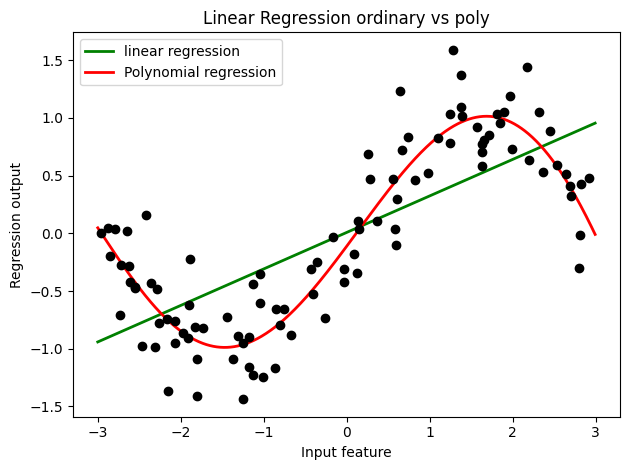

In [77]:
import matplotlib.pyplot as plt
d=5
#和上面展示一致的建模流程
LinearR = LinearRegression().fit(X, y)
X_ = PF(degree=d).fit_transform(X)
LinearR_ = LinearRegression().fit(X_, y)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)
line_ = PF(degree=d).fit_transform(line)
#放置画布
fig, ax1 = plt.subplots(1)
#将测试数据带入predict接口，获得模型的拟合效果并进行绘制
ax1.plot(line, LinearR.predict(line), linewidth=2, color='green'
         ,label="linear regression")
ax1.plot(line, LinearR_.predict(line_), linewidth=2, color='red'
         ,label="Polynomial regression")
#将原数据上的拟合绘制在图像上
ax1.plot(X[:, 0], y, 'o', c='k')
#其他图形选项
ax1.legend(loc="best")
ax1.set_ylabel("Regression output")
ax1.set_xlabel("Input feature")
ax1.set_title("Linear Regression ordinary vs poly")
plt.tight_layout()
plt.show()
#来一起鼓掌，感叹多项式回归的神奇

In [78]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [79]:
X = np.arange(9).reshape(3, 3)
X

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [80]:
poly = PolynomialFeatures(degree=5).fit(X)

In [86]:
#重要接口get_feature_names
poly.get_feature_names_out()

array(['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2',
       'x2^2', 'x0^3', 'x0^2 x1', 'x0^2 x2', 'x0 x1^2', 'x0 x1 x2',
       'x0 x2^2', 'x1^3', 'x1^2 x2', 'x1 x2^2', 'x2^3', 'x0^4', 'x0^3 x1',
       'x0^3 x2', 'x0^2 x1^2', 'x0^2 x1 x2', 'x0^2 x2^2', 'x0 x1^3',
       'x0 x1^2 x2', 'x0 x1 x2^2', 'x0 x2^3', 'x1^4', 'x1^3 x2',
       'x1^2 x2^2', 'x1 x2^3', 'x2^4', 'x0^5', 'x0^4 x1', 'x0^4 x2',
       'x0^3 x1^2', 'x0^3 x1 x2', 'x0^3 x2^2', 'x0^2 x1^3',
       'x0^2 x1^2 x2', 'x0^2 x1 x2^2', 'x0^2 x2^3', 'x0 x1^4',
       'x0 x1^3 x2', 'x0 x1^2 x2^2', 'x0 x1 x2^3', 'x0 x2^4', 'x1^5',
       'x1^4 x2', 'x1^3 x2^2', 'x1^2 x2^3', 'x1 x2^4', 'x2^5'],
      dtype=object)

In [87]:
from sklearn.datasets import fetch_california_housing as fch
import pandas as pd
housevalue = fch()
X = pd.DataFrame(housevalue.data)
y = housevalue.target

In [88]:
housevalue.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [89]:
X.columns = ["住户收入中位数","房屋使用年代中位数","平均房间数目"
           ,"平均卧室数目","街区人口","平均入住率","街区的纬度","街区的经度"]

In [90]:
poly = PolynomialFeatures(degree=2).fit(X,y)
poly.get_feature_names_out(X.columns)

array(['1', '住户收入中位数', '房屋使用年代中位数', '平均房间数目', '平均卧室数目', '街区人口', '平均入住率',
       '街区的纬度', '街区的经度', '住户收入中位数^2', '住户收入中位数 房屋使用年代中位数',
       '住户收入中位数 平均房间数目', '住户收入中位数 平均卧室数目', '住户收入中位数 街区人口',
       '住户收入中位数 平均入住率', '住户收入中位数 街区的纬度', '住户收入中位数 街区的经度', '房屋使用年代中位数^2',
       '房屋使用年代中位数 平均房间数目', '房屋使用年代中位数 平均卧室数目', '房屋使用年代中位数 街区人口',
       '房屋使用年代中位数 平均入住率', '房屋使用年代中位数 街区的纬度', '房屋使用年代中位数 街区的经度',
       '平均房间数目^2', '平均房间数目 平均卧室数目', '平均房间数目 街区人口', '平均房间数目 平均入住率',
       '平均房间数目 街区的纬度', '平均房间数目 街区的经度', '平均卧室数目^2', '平均卧室数目 街区人口',
       '平均卧室数目 平均入住率', '平均卧室数目 街区的纬度', '平均卧室数目 街区的经度', '街区人口^2',
       '街区人口 平均入住率', '街区人口 街区的纬度', '街区人口 街区的经度', '平均入住率^2', '平均入住率 街区的纬度',
       '平均入住率 街区的经度', '街区的纬度^2', '街区的纬度 街区的经度', '街区的经度^2'], dtype=object)

In [91]:
X_ = poly.transform(X)

In [92]:
#在这之后，我们依然可以直接建立模型，然后使用线性回归的coef_属性来查看什么特征对标签的影响最大
reg = LinearRegression().fit(X_,y)
coef = reg.coef_

In [95]:
coef

array([ 5.91954055e-08, -1.12430252e+01, -8.48898543e-01,  6.44105898e+00,
       -3.15913288e+01,  4.06090344e-04,  1.00386234e+00,  8.70568188e+00,
        5.88063272e+00, -3.13081272e-02,  1.85994682e-03,  4.33020468e-02,
       -1.86142278e-01,  5.72831545e-05, -2.59019509e-03, -1.52505713e-01,
       -1.44242939e-01,  2.11725336e-04, -1.26219010e-03,  1.06115056e-02,
        2.81885293e-06, -1.81716947e-03, -1.00690372e-02, -9.99950167e-03,
        7.26947730e-03, -6.89064340e-02, -6.82365908e-05,  2.68878842e-02,
        8.75089875e-02,  8.22890339e-02,  1.60180950e-01,  5.14264271e-04,
       -8.71911472e-02, -4.37042992e-01, -4.04150578e-01,  2.73779577e-09,
        1.91426762e-05,  2.29529789e-05,  1.46567733e-05,  8.71560978e-05,
        2.13344592e-02,  1.62412938e-02,  6.18867358e-02,  1.08107173e-01,
        3.99077351e-02])

In [94]:
[*zip(poly.get_feature_names_out(X.columns),reg.coef_)]

[('1', 5.919540552172341e-08),
 ('住户收入中位数', -11.243025193367208),
 ('房屋使用年代中位数', -0.8488985430012009),
 ('平均房间数目', 6.44105898010353),
 ('平均卧室数目', -31.591328788581464),
 ('街区人口', 0.0004060903437926783),
 ('平均入住率', 1.003862338673682),
 ('街区的纬度', 8.705681884585163),
 ('街区的经度', 5.880632723650293),
 ('住户收入中位数^2', -0.03130812716756877),
 ('住户收入中位数 房屋使用年代中位数', 0.0018599468175789968),
 ('住户收入中位数 平均房间数目', 0.043302046756173475),
 ('住户收入中位数 平均卧室数目', -0.18614227806342012),
 ('住户收入中位数 街区人口', 5.7283154456546e-05),
 ('住户收入中位数 平均入住率', -0.002590195088192837),
 ('住户收入中位数 街区的纬度', -0.1525057125569781),
 ('住户收入中位数 街区的经度', -0.14424293937544064),
 ('房屋使用年代中位数^2', 0.0002117253362578824),
 ('房屋使用年代中位数 平均房间数目', -0.0012621900983796669),
 ('房屋使用年代中位数 平均卧室数目', 0.01061150560837114),
 ('房屋使用年代中位数 街区人口', 2.8188529289186425e-06),
 ('房屋使用年代中位数 平均入住率', -0.0018171694688056716),
 ('房屋使用年代中位数 街区的纬度', -0.010069037156389788),
 ('房屋使用年代中位数 街区的经度', -0.009999501671415334),
 ('平均房间数目^2', 0.007269477298001186),
 ('平均房间数目 平均卧室数目',

In [96]:
#放到dataframe中进行排序
coeff = pd.DataFrame([poly.get_feature_names_out(X.columns),reg.coef_.tolist()]).T

In [99]:
coeff.head()

,feature,coef
0,1,0.0
1,住户收入中位数,-11.243025
2,房屋使用年代中位数,-0.848899
3,平均房间数目,6.441059
4,平均卧室数目,-31.591329


In [98]:
coeff.columns = ["feature","coef"]

In [100]:
coeff.sort_values(by="coef")

,feature,coef
4,平均卧室数目,-31.591329
1,住户收入中位数,-11.243025
2,房屋使用年代中位数,-0.848899
33,平均卧室数目 街区的纬度,-0.437043
34,平均卧室数目 街区的经度,-0.404151
12,住户收入中位数 平均卧室数目,-0.186142
15,住户收入中位数 街区的纬度,-0.152506
16,住户收入中位数 街区的经度,-0.144243
32,平均卧室数目 平均入住率,-0.087191
25,平均房间数目 平均卧室数目,-0.068906


In [101]:
#顺便可以查看一下多项式变化之后，模型的拟合效果如何了
poly = PolynomialFeatures(degree=4).fit(X,y)
X_ = poly.transform(X)
reg = LinearRegression().fit(X,y)
reg.score(X,y)

0.606232685199805

In [102]:
from time import time
time0 = time()
reg_ = LinearRegression().fit(X_,y)
print("R2:{}".format(reg_.score(X_,y)))
print("time:{}".format(time()-time0))

R2:0.7452033773725956
time:0.7864689826965332


In [103]:
#假设使用其他模型？
from sklearn.ensemble import RandomForestRegressor as RFR
time0 = time()
print("R2:{}".format(RFR(n_estimators=100).fit(X,y).score(X,y)))
print("time:{}".format(time()-time0))

R2:0.9743821209817376
time:14.323339462280273
